# Image Processing (and Matplotlib)
Image processing is an extremely powerful tool for biomedical engineering. Did you know that in DNA sequencing image processing is used to make judgment calls for each individual base pair being A, T, C, or G? Image processing is also used in a variety of biomedical applications, like diagnosing cancerous tumors in images of tissue, image-guided surgery, and in numerous and disparate research applications.

In this module, we will explore a very simple image processing task: how to differentiate between handwritten 0's and 1's. While on the surface this task seems unrelated to biomedical engineering, a simple leap of imagination reveals that this kind of image processing could be used to differentiate (and thus diagnose) between bacilli and cocci. In other words, by learning how to process images of 0's and 1's, you are also learning how to develop a streptococci test!
![Image of Yaktocat](bacteria-shapes.png)


In [254]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

fname0 = 'zeros.txt'
fname1 = 'ones.txt'
zeros = np.fromfile(fname0, dtype=np.int8, sep = ' ').reshape(1000, 28, 28)
ones = np.fromfile(fname1, dtype=np.int8, sep=' ').reshape(1000, 28, 28)
for i in range(1000):
    zeros[i, :, :] = zeros[i, :, :].T
    ones[i, :, :] = ones[i, :, :].T

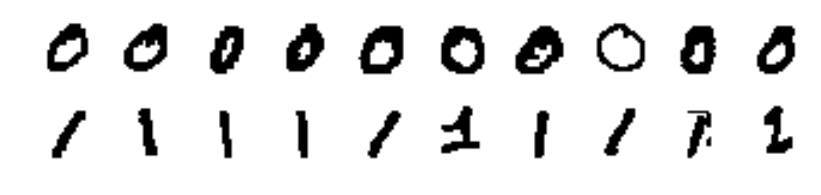

In [383]:
sample = 10
plt.figure(figsize=(sample, 2))
for i in range(sample):
    plt.subplot(2, sample, i+1)
    plt.imshow(zeros[i, :, :], cmap = matplotlib.cm.Greys)
    plt.axis('off')
    plt.subplot(2, sample, sample+i+1)
    plt.imshow(ones[i, :, :], cmap = matplotlib.cm.Greys)
    plt.axis('off')

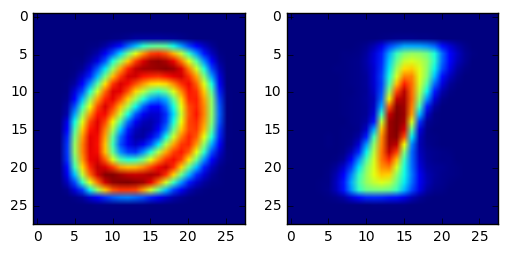

In [387]:
plt.subplot(1, 2, 1)
allzeros = np.sum(zeros, axis=0)
plt.imshow(allzeros)
plt.subplot(1, 2, 2)
allones = np.sum(ones, axis=0)
plt.imshow(allones);

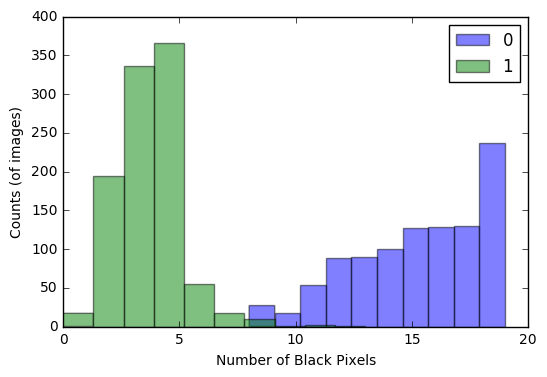

In [407]:
width0 = []
width1 = []
for i in range(1000):
    ztemp = zeros[i, 12, :]
    width0.append(np.max(np.nonzero(ztemp))-np.min(np.nonzero(ztemp)))
    otemp = ones[i, 12, :]
    width1.append(np.max(np.nonzero(otemp))-np.min(np.nonzero(otemp)))
fig, ax = plt.subplots();
ax.hist(width0, alpha = 0.5), ax.hist(width1, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');

In [406]:
np.nonzero(ztemp)

(array([ 7,  8,  9, 10, 11, 12, 13, 20, 21, 22]),)

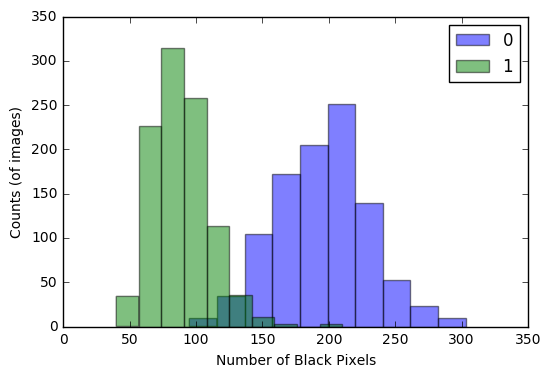

In [292]:
zavg = []
oavg = []
for i in range(1000):
    zavg.append(np.sum(zeros[i, :, :]))
    oavg.append(np.sum(ones[i, :, :]))
fig, ax = plt.subplots();
ax.hist(zavg, alpha = 0.5), ax.hist(oavg, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');

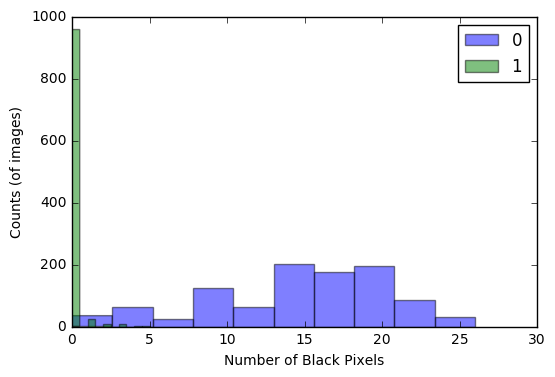

In [293]:
zavg = []
oavg = []
for i in range(1000):
    zavg.append(np.sum(zeros[i, 10:15, 20:]))
    oavg.append(np.sum(ones[i, 10:15, 20:]))
fig, ax = plt.subplots()
ax.hist(zavg, alpha = 0.5), ax.hist(oavg, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');

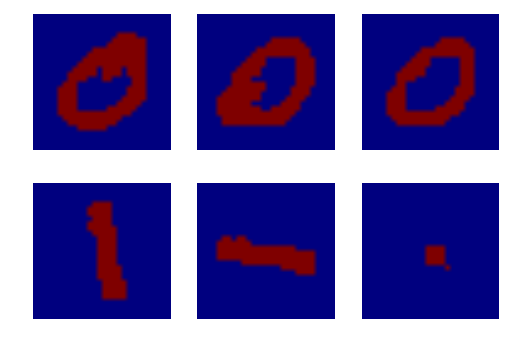

In [307]:
plt.subplot(2, 3, 1), plt.imshow(zeros[1, :, :]), plt.axis('off')
plt.subplot(2, 3, 2), plt.imshow(zeros[1, :, :].T), plt.axis('off')
plt.subplot(2, 3, 3), plt.imshow(zeros[1, :, :]*zeros[1, :, :].T), plt.axis('off')

plt.subplot(2, 3, 4), plt.imshow(ones[1, :, :]), plt.axis('off')
plt.subplot(2, 3, 5), plt.imshow(ones[1, :, :].T), plt.axis('off')
plt.subplot(2, 3, 6), plt.imshow(ones[1, :, :]*ones[1, :, :].T), plt.axis('off');

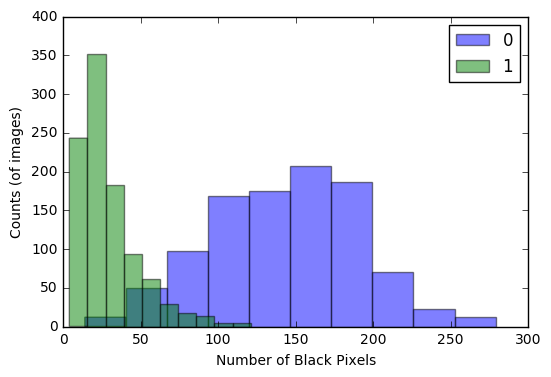

In [310]:
overlap0 = [np.sum(zeros[i, :, :]*zeros[i, :, :].T) for i in range(1000)]
overlap1 = [np.sum(ones[i, :, :]*ones[i, :, :].T) for i in range(1000)]
fig, ax = plt.subplots()
ax.hist(overlap0, alpha = 0.5), ax.hist(overlap1, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');

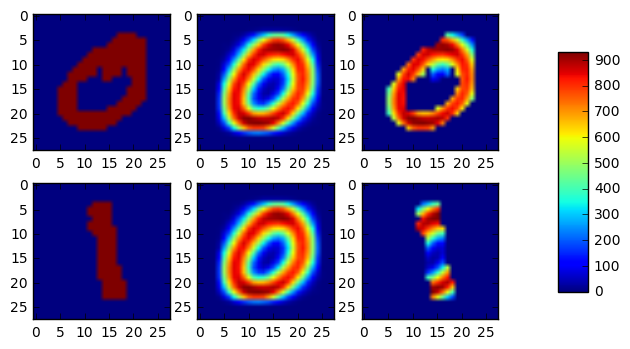

In [381]:
fig, ax= plt.subplots(2, 3)
ax[0, 0].imshow(zeros[1, :, :])
im = ax[0, 1].imshow(allzeros)
ax[0, 2].imshow(zeros[1, :, :]*allzeros)
ax[1, 0].imshow(ones[1, :, :])
ax[1, 1].imshow(allzeros)
ax[1, 2].imshow(ones[1, :, :]*allzeros);
cbar_ax = fig.add_axes([1, 0.2, .05, 0.6])
fig.colorbar(im, cax=cbar_ax)

In [339]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120e6e8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1156bf610>]], dtype=object)

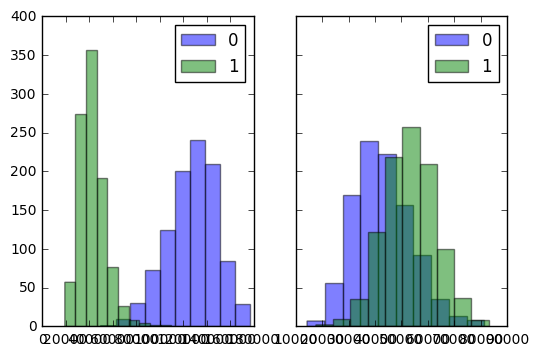

In [325]:
convolve00 = [np.sum(zeros[i, :, :]*allzeros) for i in range(1000)]
convolve10 = [np.sum(ones[i, :, :]*allzeros) for i in range(1000)]
convolve01 = [np.sum(zeros[i, :, :]*allones) for i in range(1000)]
convolve11 = [np.sum(ones[i, :, :]*allones) for i in range(1000)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(convolve00, alpha = 0.5), ax1.hist(convolve10, alpha = 0.5)
ax1.legend(['0', '1']);
ax2.hist(convolve01, alpha = 0.5), ax2.hist(convolve11, alpha = 0.5)
ax2.legend(['0', '1']); 